# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import random

from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier

# Importing Training Data

## Importing Features

In [2]:
full_path = "C:\Projects\EDA GSP"
train_path = os.path.join(full_path, "data", "train.csv")

In [3]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

train_df = pd.read_csv(train_path, dtype=dtypes)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int64   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           uint8   
 6   page            float64 
 7   room_coor_x     float32 
 8   room_coor_y     float32 
 9   screen_coor_x   float32 
 10  screen_coor_y   float32 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      category
 17  hq              category
 18  music           category
 19  level_group     category
dtypes: category(10), float32(5), float64(1), int32(1), int64(2), uint8(1)
memory usage: 1.5 GB


In [10]:
train_df.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [11]:
print("Full train dataset shape is {}".format(train_df.shape))

Full train dataset shape is (26296946, 20)


## Importing labels

In [4]:
target_path = os.path.join(full_path, "data", "train_labels.csv")
labels = pd.read_csv(target_path)


In [5]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [14]:
labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


# Answers correctness

## Total Correctness

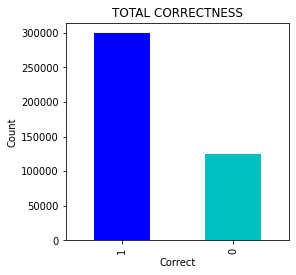

In [15]:
plt.figure(figsize=(4, 4))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

plt.title("TOTAL CORRECTNESS")
plt.xlabel("Correct")
plt.ylabel("Count")

plt.show()

## Correctness by question

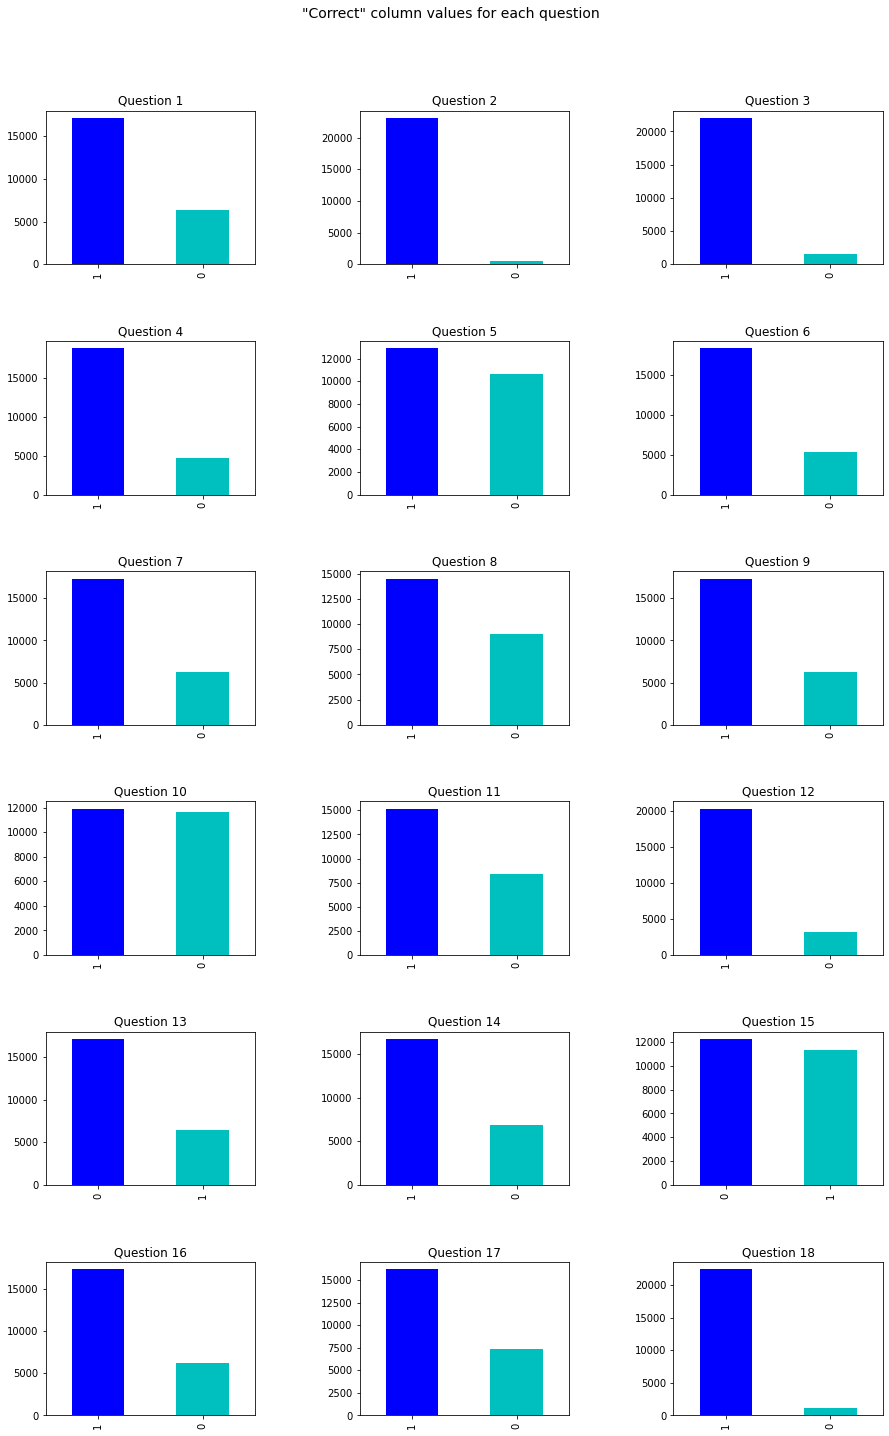

In [16]:
plt.figure(figsize=(15, 24))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(6, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['b', 'c'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("")

## Observations about correctness

Problematic questions, ordered by descending order from most problematic to less.
- 13
- 15
- 10
- 5
- 8
- 11

# Preparing the Data

En este juego las preguntas a responder aparecen después de cada checkpoint. 
Es decir, después de completar los niveles de 0-4 nos darán las preguntas de 1-3. 
Simplificandolo: 
- level_group **0-4**  preguntas **1-3**
- level_group **5-12**  preguntas **4-13**
- level_group **13-22**  preguntas **14-18**

In [6]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

Definimos una función para hacer Feature Engineering.

In [7]:
def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [8]:
dataset_df = feature_engineer(train_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

Full prepared dataset shape is (70686, 22)


In [9]:
dataset_df.columns

Index(['level_group', 'event_name_nunique', 'name_nunique', 'fqid_nunique',
       'room_fqid_nunique', 'text_fqid_nunique', 'elapsed_time', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'elapsed_time_std', 'level_std', 'page_std',
       'room_coor_x_std', 'room_coor_y_std', 'screen_coor_x_std',
       'screen_coor_y_std', 'hover_duration_std'],
      dtype='object')

In [20]:
dataset_df.head(5)

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044872,2389.500000,49246.539458,1.230975,-1.000000,399.296040,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347170,...,379.301020,899.925926,126666.129584,2.358652,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784906,969.333333,80175.676658,2.096919,-1.000000,357.227700,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045960,...,370.723077,1378.750000,67372.714092,1.232616,0.000000,445.980040,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762282,...,387.930077,720.384921,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


In [21]:
dataset_df.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
count,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,...,70686.000000,7.068600e+04,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04
mean,10.390021,3.885324,40.468650,10.268908,23.838412,2.811806e+06,9.311221,1.439995,-33.454850,-92.222834,...,379.749100,4.119625e+03,9.322398e+05,1.916549,0.038805,468.689088,183.186301,240.795420,124.016602,1.322598e+04
std,0.832923,0.799293,13.020929,2.928351,8.989095,2.289877e+07,6.523788,2.350494,80.784374,69.349051,...,36.971049,1.394260e+05,1.206491e+07,0.492239,0.785170,106.991644,48.884988,28.709135,15.844603,4.868272e+05
min,7.000000,3.000000,18.000000,5.000000,8.000000,4.591262e+02,0.923372,-1.000000,-461.440746,-409.231293,...,177.051852,-1.000000e+00,2.337003e+02,0.684670,-1.000000,261.425412,90.098532,109.415466,68.257406,-1.000000e+00
25%,10.000000,3.000000,25.000000,7.000000,15.000000,1.642777e+05,2.051613,-1.000000,-90.615673,-151.717488,...,358.117451,9.709706e+02,8.240024e+04,1.295298,-1.000000,381.066224,143.588600,222.569734,113.994303,1.368802e+03
50%,11.000000,4.000000,43.000000,11.000000,23.000000,5.882137e+05,8.140526,1.000000,-20.255625,-71.538725,...,377.843845,1.427761e+03,1.440869e+05,2.099711,0.000000,431.901351,162.941972,238.383832,122.388964,2.041432e+03
75%,11.000000,4.000000,51.000000,12.000000,32.000000,1.351434e+06,17.592593,4.000000,23.220108,-38.693486,...,397.018403,2.158794e+03,2.240529e+05,2.316163,0.735893,585.347608,233.385259,255.083349,132.067430,3.105588e+03
max,11.000000,6.000000,81.000000,17.000000,48.000000,1.191886e+09,20.222101,6.000000,328.096100,160.347986,...,986.193023,2.772298e+07,9.946229e+08,3.580235,2.715695,817.257132,349.049304,612.958607,331.833790,7.837740e+07


## Numerical data distribution

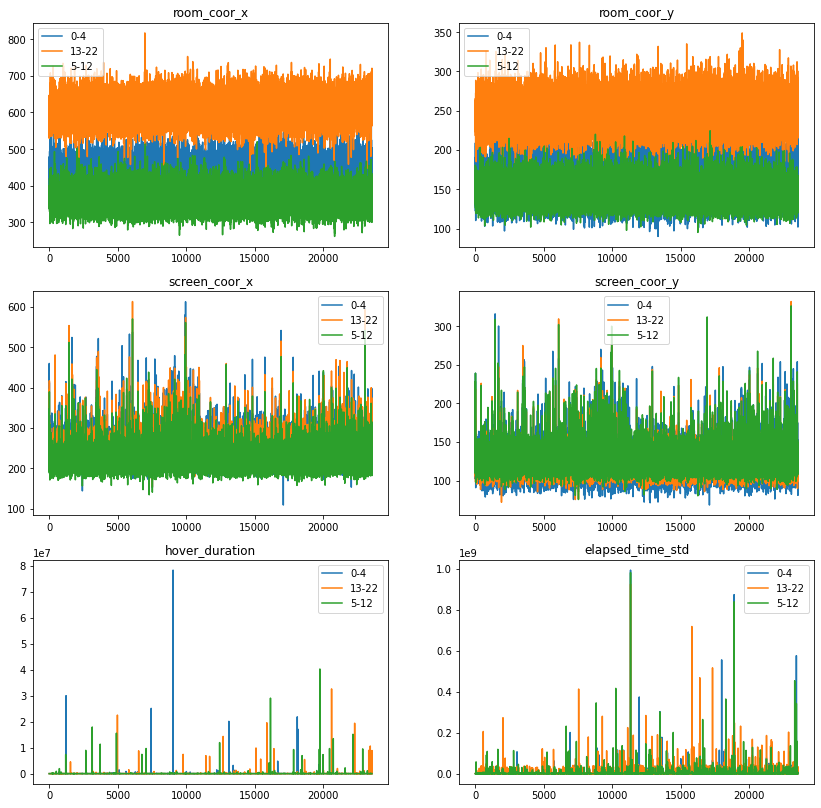

In [22]:
figure, axis = plt.subplots(3, 2, figsize=(14, 14))

for name, data in dataset_df.groupby('level_group'):
    axis[0, 0].plot(range(1, len(data['room_coor_x_std'])+1), data['room_coor_x_std'], label=name)
    axis[0, 1].plot(range(1, len(data['room_coor_y_std'])+1), data['room_coor_y_std'], label=name)
    axis[1, 0].plot(range(1, len(data['screen_coor_x_std'])+1), data['screen_coor_x_std'], label=name)
    axis[1, 1].plot(range(1, len(data['screen_coor_y_std'])+1), data['screen_coor_y_std'], label=name)
    axis[2, 0].plot(range(1, len(data['hover_duration'])+1), data['hover_duration_std'], label=name)
    axis[2, 1].plot(range(1, len(data['elapsed_time_std'])+1), data['elapsed_time_std'], label=name)
    

axis[0, 0].set_title('room_coor_x')
axis[0, 1].set_title('room_coor_y')
axis[1, 0].set_title('screen_coor_x')
axis[1, 1].set_title('screen_coor_y')
axis[2, 0].set_title('hover_duration')
axis[2, 1].set_title('elapsed_time_std')

for i in range(3):
    axis[i, 0].legend()
    axis[i, 1].legend()

plt.show()

## Train test split

In [23]:
""" def split_dataset(dataset, test_ratio=0.20, random_seed=None):
    USER_LIST = list(dataset_df.index.unique())

    if random_seed is not None:
        random.seed(random_seed)

    random.shuffle(USER_LIST)
    split = int(len(USER_LIST) * (1 - test_ratio))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]] """

' def split_dataset(dataset, test_ratio=0.20, random_seed=None):\n    USER_LIST = list(dataset_df.index.unique())\n\n    if random_seed is not None:\n        random.seed(random_seed)\n\n    random.shuffle(USER_LIST)\n    split = int(len(USER_LIST) * (1 - test_ratio))\n    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]] '

In [24]:
#train_x, valid_x = split_dataset(dataset_df, random_seed=42, test_ratio=0.2)
#print("{} examples in training, {} examples in testing.".format(len(train_x), len(valid_x)))

In [25]:
FEATURES = [c for c in dataset_df.columns if c != 'level_group']
ALL_USERS = dataset_df.index.unique()

In [26]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}


# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=dataset_df, groups=dataset_df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    
    lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.002,
    'max_depth': 6,
    'num_iterations': 1000}
    
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = dataset_df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = labels.loc[labels.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = dataset_df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = labels.loc[labels.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf =  LGBMClassifier(**lgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


4 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


6 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


7 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


8 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


9 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


10 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


11 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


12 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


13 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


14 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


15 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


16 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


18 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



#########################
### Fold 2
#########################
1 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


4 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


6 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


7 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


8 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


9 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


10 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


11 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


12 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


13 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


14 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


15 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


16 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


18 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



#########################
### Fold 3
#########################
1 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


4 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


6 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


7 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


8 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


9 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


10 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


11 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


12 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


13 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


14 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


15 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


16 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


18 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



#########################
### Fold 4
#########################
1 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


4 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


6 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


7 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


8 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


9 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


10 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


11 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


12 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


13 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


14 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


15 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


16 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


18 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



#########################
### Fold 5
#########################
1 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


4 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


6 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


7 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


8 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


9 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


10 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


11 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


12 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


13 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


14 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


15 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


16 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


18 , 

c:\Projects\EDA GSP\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [27]:
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = labels.loc[labels.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [28]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

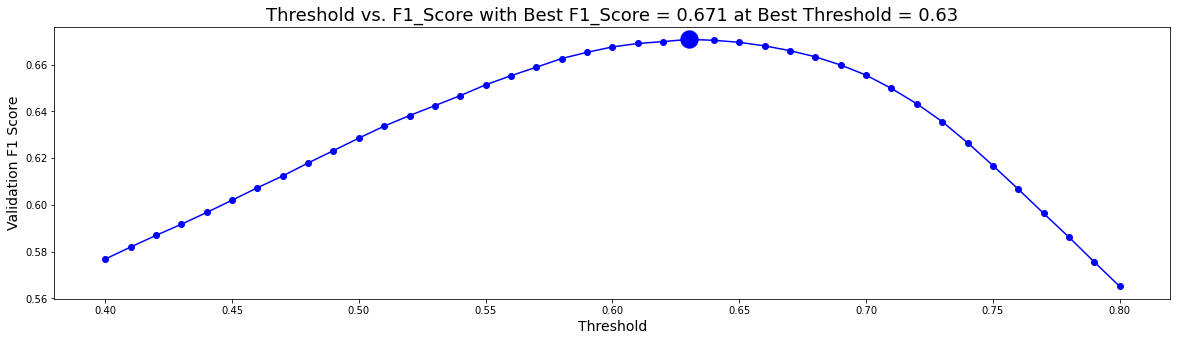

In [29]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [30]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)



When using optimal threshold...
Q0: F1 = 0.5405513764437133
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.4848198266977135
Q3: F1 = 0.5717009756673148
Q4: F1 = 0.5416767553789451
Q5: F1 = 0.5825126640834443
Q6: F1 = 0.5630585375059671
Q7: F1 = 0.5308921262880799
Q8: F1 = 0.5827480991616711
Q9: F1 = 0.4326577499596389
Q10: F1 = 0.5741168819641431
Q11: F1 = 0.4733216492812831
Q12: F1 = 0.4228094834158251
Q13: F1 = 0.5857340542148914
Q14: F1 = 0.3874940675702373
Q15: F1 = 0.4485734240046266
Q16: F1 = 0.5221955653418022
Q17: F1 = 0.48730334878255765
==> Overall F1 = 0.6707867676415191
